In [1]:
import evadb

In [2]:
cursor = evadb.connect().cursor()

/home/zh/CS6422/evadb2/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Create an UDF for the Google Cloud Vision Object Detector
cursor.query("CREATE OR REPLACE FUNCTION gvision_obj_detect IMPL  'google_cloud_vision_object_detector.py';").df()

,0
0,Function gvision_obj_detect added to the datab...


In [4]:
# Load some images into a table
cursor.query("DROP TABLE IF EXISTS MyImage;").df()
cursor.query("LOAD IMAGE 'imgs/bicycle_example.png' INTO MyImage;").df()
cursor.query("LOAD IMAGE 'imgs/example2.jpeg' INTO MyImage;").df()
cursor.query("LOAD IMAGE 'imgs/example3.jpg' INTO MyImage;").df()

,0
0,Number of loaded IMAGE: 1


In [5]:
# Set Google Cloud API key and project ID in environment variables before
# Or set them here:
import os;
os.environ["GOOGLE_CLOUD_API_KEY"] = ""
os.environ["GOOGLE_CLOUD_PROJECT_ID"] = ""

In [19]:
# Call the UDF to do the object detection
obj_loc = cursor.query("SELECT gvision_obj_detect(data) from MyImage;").df()
print(obj_loc)

                   gvision_obj_detect.name  \
0  [Bicycle wheel, Bicycle wheel, Bicycle]   
1  [Sunglasses, Single-lens reflex camera]   
2         [Tire, Chair, Table, Motorcycle]   

                            gvision_obj_detect.score  \
0  [0.9315302968025208, 0.9276609420776367, 0.888...   
1            [0.902370035648346, 0.7536534070968628]   
2  [0.7108969688415527, 0.708628237247467, 0.6690...   

                           gvision_obj_detect.bounds  
0  [[303.37843894958496, 503.4145736694336, 423.4...  
1  [[211.88873052597046, 179.4424057006836, 299.0...  
2  [[544.2019987106323, 832.6579590439796, 617.87...  


In [11]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_images(detections, input_images_paths):
    '''A helper function marking the detected objects on the original images'''
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=3

    for df, path in zip(detections[['gvision_obj_detect.name', 'gvision_obj_detect.bounds']].values, input_images_paths):
        # print(df, path)
        img = cv2.imread(path)
        for label, bbox in zip(df[0], df[1]):
            x1, y1, x2, y2 = bbox
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            # object bbox
            img=cv2.rectangle(img, (x1, y1), (x2, y2), color1, thickness) 
            # object label
            cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color2, thickness) 

        plt.imshow(img)
        plt.show()

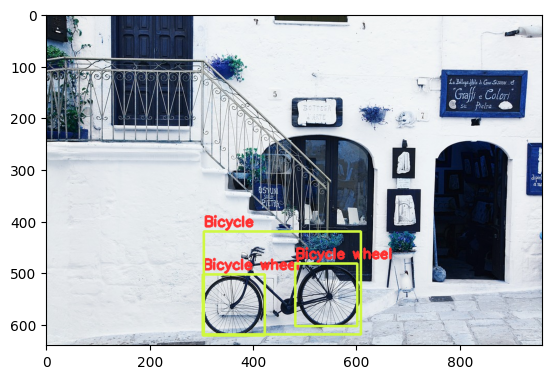

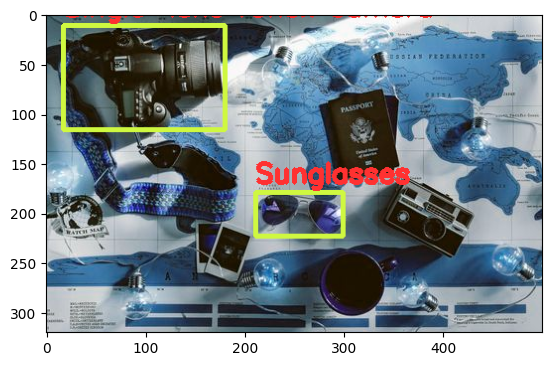

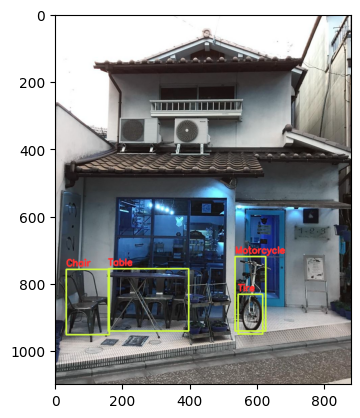

In [20]:
img_names = cursor.query("select name from MyImage;").df().values.tolist()
img_names = [e[0] for e in img_names]

# Mark the detected objects on the original images
annotate_images(obj_loc, img_names)